In [5]:
import pandas as pd
import numpy as np
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

FIRST TEST - is there a difference in total incidents of delays in days with good and bad weathaer



NOTE: using such approach will led to significant difference in observations of Good and Bad days. Hence, we can use Permutation test. This approach is robust to imbalanced sample sizes and doesn't rely on distributional assumptions.

In [6]:
merged_df = pd.read_excel('merged-data.xlsx')

In [8]:
# Define the conditions for good and bad weather
bad_weather_codes = [53, 63, 73, 81, 55, 57, 65, 67, 75, 77, 82, 86]

# Create a new column to categorize the weather as good or bad
merged_df['Weather_Category_Extreme'] = merged_df['weather_code'].apply(lambda x: 'Bad' if x in bad_weather_codes else 'Good')

In [9]:
# Group the data by the weather category and calculate the total incidents for each category
weather_groups_ex = merged_df.groupby('Weather_Category_Extreme')['Total Incidents'].sum()

# Display the total incidents for good and bad weather
weather_groups_ex

Weather_Category_Extreme
Bad     33509
Good    81405
Name: Total Incidents, dtype: int64

In [10]:
# Group the data by the weather category and calculate the total number of days for each category
weather_days_ex_days = merged_df.groupby('Weather_Category_Extreme').size()

# Display the total incidents for good and bad weather
weather_days_ex_days

Weather_Category_Extreme
Bad     208
Good    522
dtype: int64

In [11]:
good_weather_ex_data = merged_df[merged_df['Weather_Category_Extreme'] == 'Good']['Total Incidents']
bad_weather_ex_data = merged_df[merged_df['Weather_Category_Extreme'] == 'Bad']['Total Incidents']

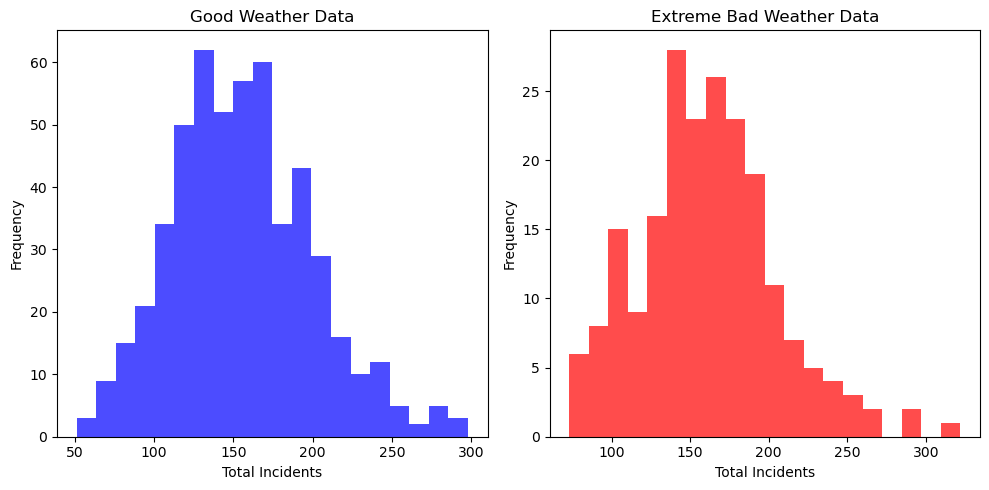

In [12]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Separate the data into good and bad weather groups
good_weather_ex_data = merged_df[merged_df['Weather_Category_Extreme'] == 'Good']['Total Incidents']
bad_weather_ex_data = merged_df[merged_df['Weather_Category_Extreme'] == 'Bad']['Total Incidents']

# Plot histograms to visualize the distribution of data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(good_weather_ex_data, bins=20, color='blue', alpha=0.7)
plt.title('Good Weather Data')
plt.xlabel('Total Incidents')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(bad_weather_ex_data, bins=20, color='red', alpha=0.7)
plt.title('Extreme Bad Weather Data')
plt.xlabel('Total Incidents')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
# Perform Shapiro-Wilk test for normality
_, good_weather_pval = shapiro(good_weather_ex_data)
_, extreme_bad_weather_pval = shapiro(bad_weather_ex_data)

print("Shapiro-Wilk test for normality:")
print("Good Weather p-value:", good_weather_pval)
print("Bad Weather p-value:", extreme_bad_weather_pval)

Shapiro-Wilk test for normality:
Good Weather p-value: 0.0001109786971937865
Bad Weather p-value: 0.0033908188343048096


Normality not met. Hence, we need to use non-parametric test. 

However, having very different sample sizes can influence the robustness of statistical tests to violations of the homogeneity of variance assumption. Specifically:

Unequal variances (heteroscedasticity): If the variances are unequal and the sample sizes are very different, standard tests (like the t-test) that assume equal variances can become unreliable. This is because these tests may have inflated Type I or Type II error rates.

Levene's test or Brown-Forsythe test: These tests can be used to formally test the assumption of equal variances. They are less sensitive to departures from normality compared to other tests.

Alternative methods: If you suspect that the variances are not equal, you can use alternative statistical methods that do not assume equal variances. For example, Welch's t-test is an adaptation of the t-test that does not assume equal variances and can be more reliable when sample sizes are unequal.

In summary, while different sample sizes do not directly indicate a violation of the homogeneity of variance assumption, they can exacerbate the consequences of such a violation if it exists. Therefore, it is always good practice to check the homogeneity of variance when dealing with groups of significantly different sizes and consider using robust statistical methods if the assumption is violated.

Lets try applying Permutation test!

Permutation tests are non-parametric tests that do not rely on distributional assumptions such as homogeneity of variance. Instead, permutation tests directly utilize the observed data to generate the null distribution of the test statistic by shuffling or permuting the data. This makes permutation tests robust to violations of assumptions like homogeneity of variance.

In [14]:
# Define the observed difference in means between good and bad weather days
observed_diff = np.mean(good_weather_ex_data) - np.mean(bad_weather_ex_data)

# Combine the data from both groups
combined_data = np.concatenate((good_weather_ex_data, bad_weather_ex_data))

# Set the number of permutations
num_permutations = 100000

# Initialize an array to store permutation differences
perm_diffs = np.zeros(num_permutations)

# Perform permutation sampling
for i in range(num_permutations):
    # Shuffle the combined data
    np.random.shuffle(combined_data)
    
    # Split the shuffled data into two groups
    perm_good_weather = combined_data[:len(good_weather_ex_data)]
    perm_bad_weather = combined_data[len(good_weather_ex_data):] #check this thing !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    # Calculate the difference in means for the permutation
    perm_diffs[i] = np.mean(perm_good_weather) - np.mean(perm_bad_weather)

# Calculate the p-value
p_value = np.mean(perm_diffs >= observed_diff)

print("Permutation test p-value:", p_value)

Permutation test p-value: 0.92314


Text(0.5, 1.0, 'Histogram of Mean difference for our permutation tests')

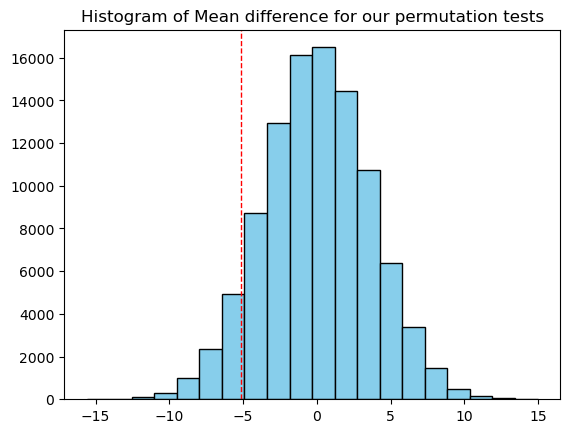

In [15]:
plt.hist(perm_diffs, bins=20, color='skyblue', edgecolor='black')

# Add a vertical line at value mean_dif_orig_value
plt.axvline(x=observed_diff, color='red', linestyle='--', linewidth=1)
plt.title('Histogram of Mean difference for our permutation tests')

There's insufficient evidence to reject the null hypothesis of no difference between the two weather conditions in terms of total incidents of delays. Therefore, based on the results of the permutation test, you cannot conclude that there is a statistically significant difference between good and bad weather days regarding delays.


So even when we focus on more extreme conditions while defining bad weather - there is no statistial difference between bus delays and weather conditions

---------------------------------------------------------


SECOND QUESTION: Do certain types of delays happen more often in bad weather? We want to find out which


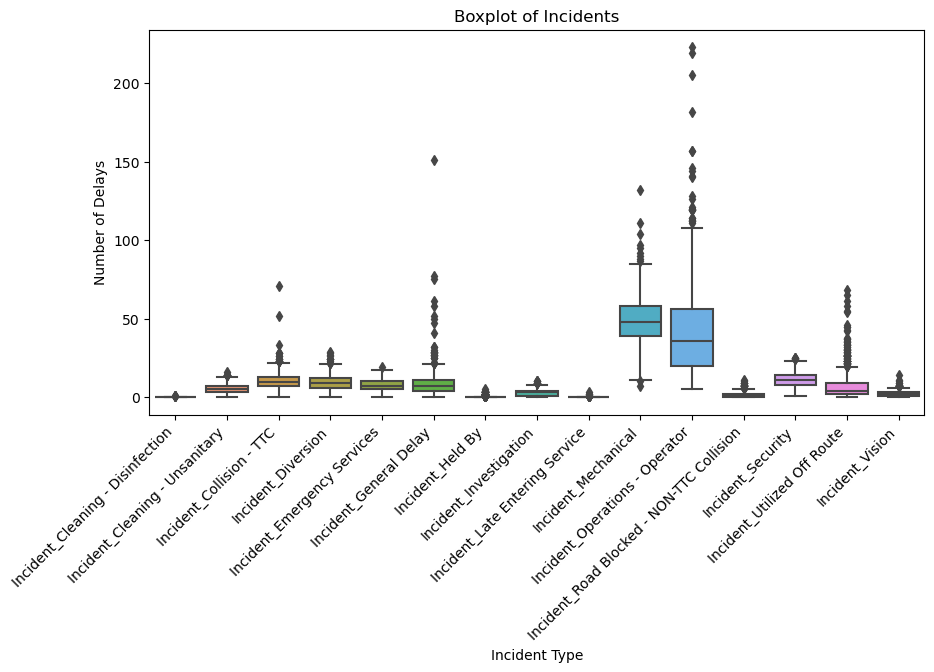

In [17]:
import seaborn as sns

# Define the incident columns
incident_columns = ['Incident_Cleaning - Disinfection',
       'Incident_Cleaning - Unsanitary', 'Incident_Collision - TTC',
       'Incident_Diversion', 'Incident_Emergency Services',
       'Incident_General Delay', 'Incident_Held By', 'Incident_Investigation',
       'Incident_Late Entering Service', 'Incident_Mechanical',
       'Incident_Operations - Operator',
       'Incident_Road Blocked - NON-TTC Collision', 'Incident_Security',
       'Incident_Utilized Off Route', 'Incident_Vision']

# Plot boxplots for each incident type
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_df[incident_columns])
plt.title('Boxplot of Incidents')
plt.xlabel('Incident Type')
plt.ylabel('Number of Delays')
plt.xticks(rotation=45, ha='right')
plt.show()

it is visible that there are no normality assumption met because of outliers

In [18]:
# Define the incident columns
incident_columns = ['Incident_Cleaning - Disinfection',
       'Incident_Cleaning - Unsanitary', 'Incident_Collision - TTC',
       'Incident_Diversion', 'Incident_Emergency Services',
       'Incident_General Delay', 'Incident_Held By', 'Incident_Investigation',
       'Incident_Late Entering Service', 'Incident_Mechanical',
       'Incident_Operations - Operator',
       'Incident_Road Blocked - NON-TTC Collision', 'Incident_Security',
       'Incident_Utilized Off Route', 'Incident_Vision']

In [19]:
grouped = merged_df.groupby('Weather_Category_Extreme')[incident_columns].mean()
grouped

,Incident_Cleaning - Disinfection,Incident_Cleaning - Unsanitary,Incident_Collision - TTC,Incident_Diversion,Incident_Emergency Services,Incident_General Delay,Incident_Held By,Incident_Investigation,Incident_Late Entering Service,Incident_Mechanical,Incident_Operations - Operator,Incident_Road Blocked - NON-TTC Collision,Incident_Security,Incident_Utilized Off Route,Incident_Vision
Weather_Category_Extreme,,,,,,,,,,,,,,,
Bad,0.004808,4.908654,11.062500,9.370192,7.283654,10.682692,0.336538,2.677885,0.072115,52.355769,40.908654,1.245192,11.254808,6.932692,2.004808
Good,0.009579,5.157088,9.808429,9.078544,7.515326,8.036398,0.323755,3.057471,0.047893,47.536398,42.977011,1.176245,11.187739,7.971264,2.065134


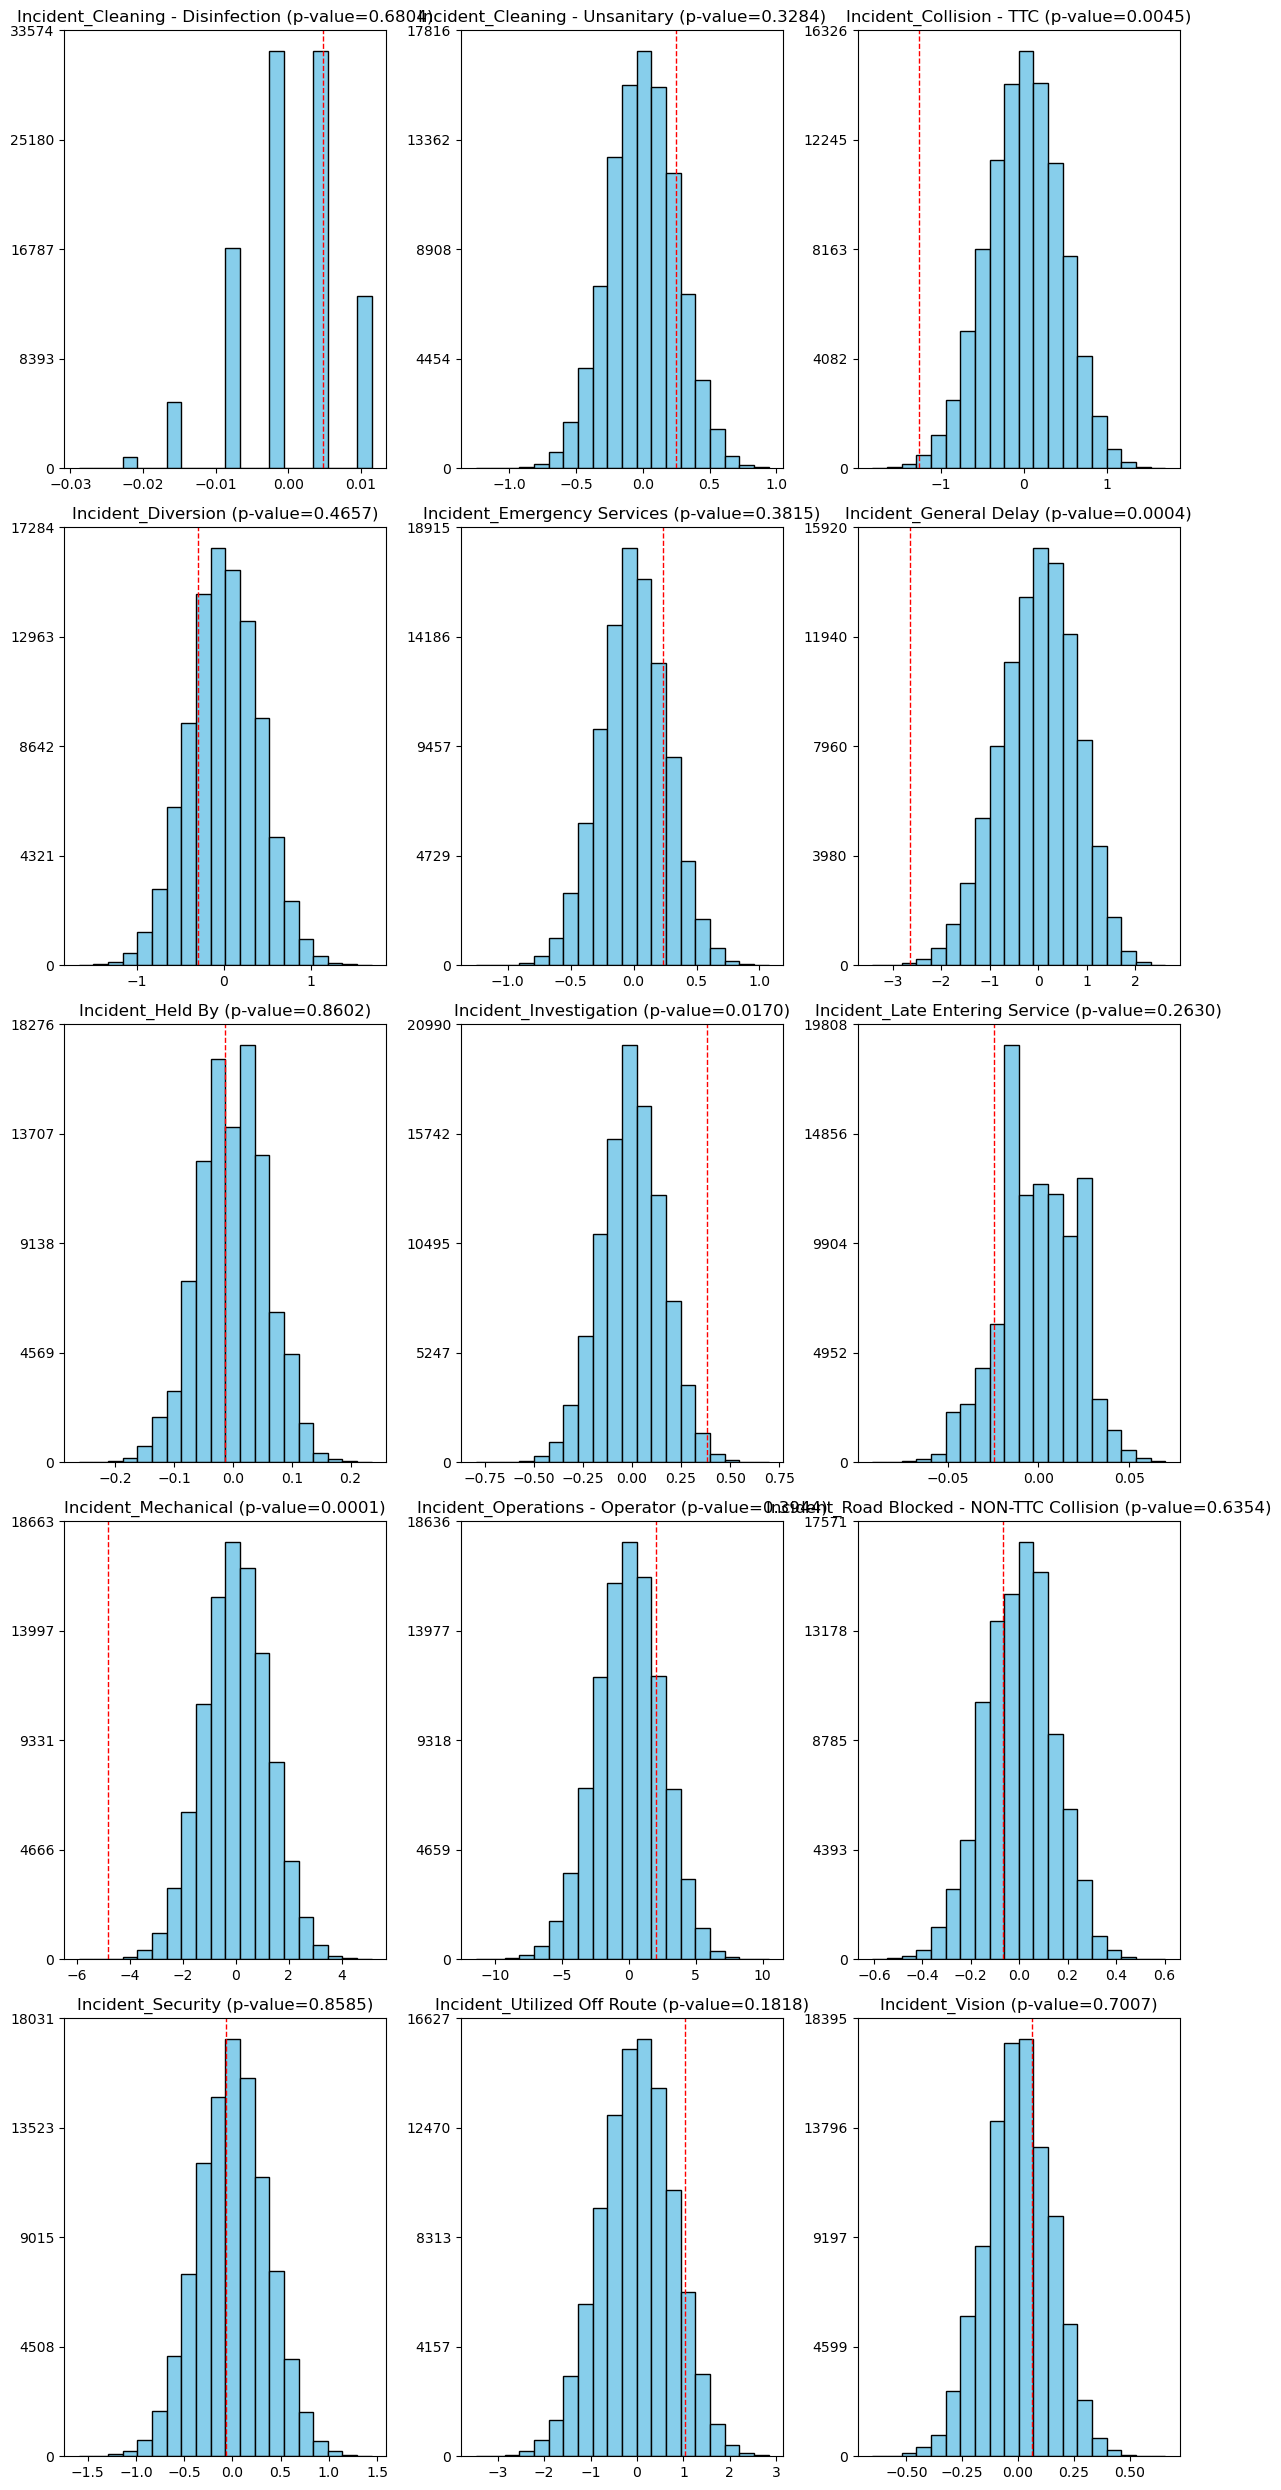

In [20]:
# Determine the number of rows and columns for subplots
num_columns = len(incident_columns)
num_rows = int(np.ceil(num_columns / 3))  # Divide the columns into rows, rounding up

# Increase height of each subplot
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 25))  # Increase the height from 6 to 25

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(incident_columns):
    # Extract data for good and bad weather
    good_weather = merged_df[merged_df['Weather_Category_Extreme'] == 'Good'][column]
    bad_weather = merged_df[merged_df['Weather_Category_Extreme'] == 'Bad'][column]

    # Calculate observed mean difference
    observed_mean_diff = np.mean(good_weather) - np.mean(bad_weather)

    # Combine all data points
    all_data = np.concatenate([good_weather, bad_weather])

    # Initialize an array to store permutation test mean differences
    permutation_mean_diffs = []

    # Set the number of permutations
    num_permutations = 100000

    # Perform permutations and calculate the mean difference for each permutation
    for _ in range(num_permutations):
        np.random.shuffle(all_data)
        permuted_good_weather = all_data[:len(good_weather)]
        permuted_bad_weather = all_data[len(good_weather):]
        permutation_mean_diff = np.mean(permuted_good_weather) - np.mean(permuted_bad_weather)
        permutation_mean_diffs.append(permutation_mean_diff)

    # Calculate the p-value as the proportion of permutations with a mean difference more extreme than the observed
    p_value = np.mean(np.abs(permutation_mean_diffs) >= np.abs(observed_mean_diff))

    # Print the results
    #print(f'Permutation test for {column}: p-value = {p_value}')

    # Plotting results in subplots
    ax = axes[i]

    ax.hist(permutation_mean_diffs, bins=20, color='skyblue', edgecolor='black')
    ax.axvline(x=observed_mean_diff, color='red', linestyle='--', linewidth=1)
    ax.set_title(f'{column} (p-value={p_value:.4f})')  # Add title with column name and p-value
    
    # Ensure at least 5 data points on y-axis
    ax.set_yticks(np.linspace(0, ax.get_ylim()[1], 5))

# Adjust layout
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()  # Display the plot


In order to answer our second question, we did applied permutation test to each of the 15 groups mentioned. In order to control family-wise error rate, Bonferroni correction been applied to our original alpha value of 0.05. Because we did 15 tests, corrected alpha value will be 0.05/15 = 0.0033. Bonferroni correction will help us to mitigate the risk of Type I errors when testing multiple hypotheses.


Within this methodology, only delays with Mechanical and General reasons were found statistically different between good and extreme bad weather days.